In [32]:
#import packages and modules
import os
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.python import pywrap_tensorflow
from keras.layers.core import Flatten, Dense, Dropout,Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np
import h5py
import pandas as pd
from scipy.misc import imread, imresize
%matplotlib inline
import matplotlib.pyplot as plt
import json
import random
from keras.layers.advanced_activations import LeakyReLU, PReLU
import sklearn
import scipy
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from keras import backend as K
K.set_image_dim_ordering('th')

In [33]:
#from sklearn import cross_validation

def count_num_files(path):
    return(sum([len(files) for files in os.walk(path)]))

def list_fileNames(path):
    filenames=[]
    for path, subdirs, files in os.walk(path):
        filenames.extend([filename for filename in files])
    return(filenames)

def split_data(X,y,val_proportion):
    X_train,X_Val,y_train,y_Val=train_test_split(X, y,test_size=val_proportion, random_state=0)
    return X_train, X_Val, y_train, y_Val;

# path to the model weights file.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'

# dimensions of our images.
img_width, img_height = 224,224
nb_epoch = 25

# directory of our data.
train_data_dir = 'data/train'
test_data_dir='data/test'

train_filenames = np.array(list_fileNames(train_data_dir))
labels= train_filenames.view(np.chararray).ljust(3)
train_labels=np.array(list(map(lambda x:(0 if x=='cat' else 1),labels)))

test_filenames = np.array(list_fileNames(test_data_dir))
labels= test_filenames.view(np.chararray).ljust(3)
test_labels=np.array(list(map(lambda x:(0 if x=='cat' else 1),labels)))

nb_train_samples =train_labels.shape[0]
nb_test_samples=test_labels.shape[0]

#print(nb_train_samples,nb_test_samples)
#print(train_labels.sum(),test_labels.sum())

In [4]:
def load_VGG16():
    # build the VGG16 network
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # load the weights of the VGG16 networks
    # (trained on ImageNet, won the ILSVRC competition in 2014)
    # note: when there is a complete match between your model definition
    # and your weight savefile, you can simply call model.load_weights(filename)
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')
    return (model)


def feature_extractor(model,path,nb_samples):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
            path,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
    bottleneck_features = model.predict_generator(generator, nb_samples)
    return (bottleneck_features)
    
def save_bottlebeck_features():
    model=load_VGG16()
    
    bottleneck_features_train = feature_extractor(model,train_data_dir,nb_train_samples)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
 
    bottleneck_features_test = feature_extractor(model,test_data_dir,nb_test_samples)
    np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)


In [71]:
#Training model for linear claasifier
def load_linear_model(input_data_shape=1,train=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(1, activation='sigmoid'))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_linear_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_linear_model(X_train.shape[1:],1)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)

train_linear_model()

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 0s - loss: 7.3125 - acc: 0.4987 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 2/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 3/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 4/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 5/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 6/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 7/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 8/25
800/800 [==============================] - 0s - loss: 8.0188 - acc: 0.5025 - val_l

In [72]:
#Test accuracy of linear model

test_data = np.load(open('bottleneck_features_test.npy','rb'))

top_model = load_linear_model(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)

acc 50.0


In [5]:
#Training model for linear claasifier with regularization
from keras.regularizers import l2, activity_l2

def load_linear_modelwithWreg(input_data_shape=1,train=0,reg=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(1, activation='sigmoid',W_regularizer=l2(reg)))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_linear_modelwithWreg(reg):
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_linear_modelwithWreg(X_train.shape[1:],1,reg)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)

train_linear_modelwithWreg(0.001)


Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 0s - loss: 7.6135 - acc: 0.4987 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 2/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 3/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 4/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 5/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 6/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 7/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_loss: 7.8138 - val_acc: 0.5100
Epoch 8/25
800/800 [==============================] - 0s - loss: 8.0131 - acc: 0.4975 - val_l

In [6]:
#Test accuracy of linear model with regularization

test_data = np.load(open('bottleneck_features_test.npy','rb'))
top_model = load_linear_modelwithWreg(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)
    

acc 50.0


Train on 500 samples, validate on 500 samples
Epoch 1/25
500/500 [==============================] - 0s - loss: 7.3096 - acc: 0.5140 - val_loss: 8.1965 - val_acc: 0.4860
Epoch 2/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1965 - val_acc: 0.4860
Epoch 3/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1965 - val_acc: 0.4860
Epoch 4/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1965 - val_acc: 0.4860
Epoch 5/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1964 - val_acc: 0.4860
Epoch 6/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1964 - val_acc: 0.4860
Epoch 7/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_loss: 8.1964 - val_acc: 0.4860
Epoch 8/25
500/500 [==============================] - 0s - loss: 7.7501 - acc: 0.5140 - val_l

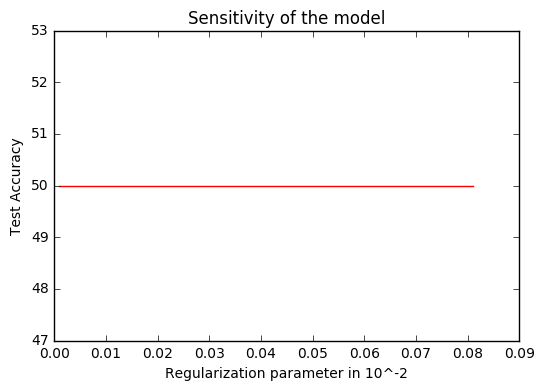

In [13]:
#plotting test accuracy as a function of regularization parameter
test_data = np.load(open('bottleneck_features_test.npy','rb'))

test_acc=[]
reg_values=[]
for reg in range(1, 100, 20):
    train_linear_modelwithWreg(reg/1000)
    top_model = load_linear_modelwithWreg(test_data.shape[1:])
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    scores = top_model.evaluate(test_data, test_labels, verbose=0)
    reg_values.append(reg/1000)
    test_acc.append(scores[1]*100)
    
plt.plot(reg_values,test_acc,'r',label = "Test accuracy") 
plt.xlabel("Regularization parameter")
plt.ylabel("Test Accuracy")
plt.title("Sensitivity of the model")
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()
    

In [26]:
# Training model with two layers and relu activation

nb_epoch=50
def load_relu_model(input_data_shape=1,train=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_relu_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_relu_model(X_train.shape[1:],1)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)
    
train_relu_model()

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 2s - loss: 0.9193 - acc: 0.5625 - val_loss: 0.6944 - val_acc: 0.5100
Epoch 2/50
800/800 [==============================] - 2s - loss: 0.6880 - acc: 0.5600 - val_loss: 0.6610 - val_acc: 0.5300
Epoch 3/50
800/800 [==============================] - 2s - loss: 0.6483 - acc: 0.6175 - val_loss: 0.6654 - val_acc: 0.5100
Epoch 4/50
800/800 [==============================] - 2s - loss: 0.6152 - acc: 0.6550 - val_loss: 0.6096 - val_acc: 0.6250
Epoch 5/50
800/800 [==============================] - 2s - loss: 0.6189 - acc: 0.6450 - val_loss: 0.5597 - val_acc: 0.7500
Epoch 6/50
800/800 [==============================] - 2s - loss: 0.5349 - acc: 0.7500 - val_loss: 0.4959 - val_acc: 0.8100
Epoch 7/50
800/800 [==============================] - 2s - loss: 0.5470 - acc: 0.7263 - val_loss: 0.5122 - val_acc: 0.8000
Epoch 8/50
800/800 [==============================] - 2s - loss: 0.5187 - acc: 0.7587 - val_l

In [27]:
#Accuracy on testing data for two layers and relu activation

test_data = np.load(open('bottleneck_features_test.npy','rb'))
top_model = load_relu_model(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)
    

acc 77.9999998411


In [19]:
# Training model with two layers and relu activation
def load_Leakyrelu_model(input_data_shape=1,train=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(256))
    top_model.add(LeakyReLU(alpha=.001)) # adding leakyrelu activation
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_Leakyrelu_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_Leakyrelu_model(X_train.shape[1:],1)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)
    
train_Leakyrelu_model()

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 2s - loss: 0.9797 - acc: 0.5225 - val_loss: 0.6625 - val_acc: 0.7100
Epoch 2/25
800/800 [==============================] - 2s - loss: 0.6554 - acc: 0.6075 - val_loss: 0.6313 - val_acc: 0.7750
Epoch 3/25
800/800 [==============================] - 2s - loss: 0.6238 - acc: 0.6500 - val_loss: 0.5908 - val_acc: 0.7850
Epoch 4/25
800/800 [==============================] - 2s - loss: 0.5791 - acc: 0.7112 - val_loss: 0.5896 - val_acc: 0.6700
Epoch 5/25
800/800 [==============================] - 2s - loss: 0.5705 - acc: 0.7000 - val_loss: 0.6172 - val_acc: 0.6050
Epoch 6/25
800/800 [==============================] - 2s - loss: 0.5641 - acc: 0.7300 - val_loss: 0.6757 - val_acc: 0.5450
Epoch 7/25
800/800 [==============================] - 2s - loss: 0.5631 - acc: 0.7050 - val_loss: 0.4976 - val_acc: 0.7600
Epoch 8/25
800/800 [==============================] - 2s - loss: 0.5321 - acc: 0.7462 - val_l

In [20]:
#Accuracy on testing data for two layers and Leakyrelu activation

test_data = np.load(open('bottleneck_features_test.npy','rb'))
top_model = load_Leakyrelu_model(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)

acc 82.6666663488


In [8]:
# Training model with two layers and tanh activation
def load_tanh_model(input_data_shape=1,train=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(256,activation='tanh'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_tanh_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_tanh_model(X_train.shape[1:],1)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)
    
train_tanh_model()

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 2s - loss: 1.1210 - acc: 0.4975 - val_loss: 0.6562 - val_acc: 0.6000
Epoch 2/25
800/800 [==============================] - 2s - loss: 0.8695 - acc: 0.5000 - val_loss: 0.7855 - val_acc: 0.5100
Epoch 3/25
800/800 [==============================] - 2s - loss: 0.7765 - acc: 0.5675 - val_loss: 0.5661 - val_acc: 0.7200
Epoch 4/25
800/800 [==============================] - 2s - loss: 0.7282 - acc: 0.6163 - val_loss: 0.5766 - val_acc: 0.6450
Epoch 5/25
800/800 [==============================] - 2s - loss: 0.5985 - acc: 0.6925 - val_loss: 0.5572 - val_acc: 0.6500
Epoch 6/25
800/800 [==============================] - 2s - loss: 0.7930 - acc: 0.6050 - val_loss: 0.5692 - val_acc: 0.7000
Epoch 7/25
800/800 [==============================] - 2s - loss: 0.6515 - acc: 0.6737 - val_loss: 0.5055 - val_acc: 0.7550
Epoch 8/25
800/800 [==============================] - 2s - loss: 0.6175 - acc: 0.6900 - val_l

In [12]:
#Accuracy on testing data for two layers and tanh activation

test_data = np.load(open('bottleneck_features_test.npy','rb'))
top_model = load_tanh_model(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)

acc 80.6666667461


In [15]:
# Training Cross validation with two layers and relu activation
def load_relu_model(input_data_shape=1,train=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_relu_model_crossval():
    
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    cv = cross_validation.KFold(len(train_data), n_folds=5, shuffle=True)
    i = 0
    for train_indices, test_indices in cv:
        i = i + 1  
        top_model = load_relu_model(train_data[train_indices].shape[1:],1)
        top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
        top_model.fit(train_data[train_indices], train_labels[train_indices],
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(train_data[test_indices], train_labels[test_indices]))
    top_model.save_weights(top_model_weights_path)
    
train_relu_model_crossval()

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 2s - loss: 0.8955 - acc: 0.5487 - val_loss: 0.7248 - val_acc: 0.5100
Epoch 2/25
800/800 [==============================] - 2s - loss: 0.6659 - acc: 0.5988 - val_loss: 0.6305 - val_acc: 0.5850
Epoch 3/25
800/800 [==============================] - 2s - loss: 0.6384 - acc: 0.6250 - val_loss: 0.5985 - val_acc: 0.7300
Epoch 4/25
800/800 [==============================] - 2s - loss: 0.6301 - acc: 0.6613 - val_loss: 0.5557 - val_acc: 0.7950
Epoch 5/25
800/800 [==============================] - 2s - loss: 0.5940 - acc: 0.6775 - val_loss: 0.5923 - val_acc: 0.6400
Epoch 6/25
800/800 [==============================] - 2s - loss: 0.5840 - acc: 0.6925 - val_loss: 0.5096 - val_acc: 0.7950
Epoch 7/25
800/800 [==============================] - 2s - loss: 0.5483 - acc: 0.7188 - val_loss: 0.5841 - val_acc: 0.6350
Epoch 8/25
800/800 [==============================] - 2s - loss: 0.4959 - acc: 0.7675 - val_l

In [16]:
test_data = np.load(open('bottleneck_features_test.npy','rb'))
top_model = load_relu_model(test_data.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
scores = top_model.evaluate(test_data, test_labels, verbose=0)
print(top_model.metrics_names[1], scores[1]*100)

acc 75.9999997616


In [29]:
#Training model for relu clasifier with regularization
from keras.regularizers import l2, activity_l2

def load_relu_modelwithWreg(input_data_shape=1,train=0,reg=0):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_data_shape))
    top_model.add(Dense(256,activation='relu',W_regularizer=l2(reg)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid',W_regularizer=l2(reg)))
    if train==0:
        top_model.load_weights(top_model_weights_path)    
    return(top_model)

def train_relu_modelwithWreg(reg):
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    X_train, X_Val, y_train, y_Val=split_data(train_data,train_labels,0.2)
    top_model = load_relu_modelwithWreg(X_train.shape[1:],1,reg)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(X_train, y_train,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(X_Val, y_Val))
    top_model.save_weights(top_model_weights_path)

In [ ]:
#plotting relu model test accuracy as a function of regularization parameter
test_data = np.load(open('bottleneck_features_test.npy','rb'))

test_acc=[]
reg_values=[]
for reg in range(1, 100, 20):
    train_relu_modelwithWreg(reg/1000)
    top_model = load_relu_modelwithWreg(test_data.shape[1:])
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    top_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    scores = top_model.evaluate(test_data, test_labels, verbose=0)
    reg_values.append(reg/1000)
    test_acc.append(scores[1]*100)
    
plt.plot(reg_values,test_acc,'r',label = "Test accuracy") 
plt.xlabel("Regularization parameter")
plt.ylabel("Test Accuracy")
plt.title("Sensitivity of the model")
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 6s - loss: 1.4738 - acc: 0.5262 - val_loss: 1.2396 - val_acc: 0.5100
Epoch 2/25
800/800 [==============================] - 5s - loss: 1.1696 - acc: 0.6000 - val_loss: 1.1955 - val_acc: 0.4900
Epoch 3/25
800/800 [==============================] - 5s - loss: 1.1499 - acc: 0.6550 - val_loss: 1.1253 - val_acc: 0.5400
Epoch 4/25
800/800 [==============================] - 5s - loss: 1.1253 - acc: 0.6438 - val_loss: 1.0891 - val_acc: 0.6700
Epoch 5/25
800/800 [==============================] - 5s - loss: 1.0974 - acc: 0.6938 - val_loss: 1.0621 - val_acc: 0.8050
Epoch 6/25
800/800 [==============================] - 5s - loss: 1.0980 - acc: 0.7112 - val_loss: 1.0125 - val_acc: 0.8400
Epoch 7/25
800/800 [==============================] - 5s - loss: 1.0295 - acc: 0.7538 - val_loss: 1.0528 - val_acc: 0.6650
Epoch 8/25
800/800 [==============================] - 5s - loss: 1.0341 - acc: 0.7338 - val_l